# Confronto tra un numero fissato di trotter steps e uno in aumento

In questo notebook proviamo a confrontare due curve: una con 12 trotter steps fissati dall'inizio, e una che arriva a 12 trotter steps nell'intervallo aumentandone il numero ad ogni dt.



## 12 TROTTER STEPS
Facciamo un primo tentativo con un intervallo di T = 3 sec e con un dt di 12 steps, in modo che a T = 3 arrivi con esattamente 12 trotter_steps, quindi ad ogni time step corrisponde un trotter step aggiuntivo

Trotter_steps_fixed = 12 T = 3 t_steps (time step) = 12 dt = 3/12 = 0.25

La differenza sostanziale sta nel guardare come il circuito deve essere “tradotto” da gates teorici a operazioni sull’hardware prima di essere eseguito.
Questo step è anche detto “transpilazione” e in Qiskit è ora a carico dell’utente. 
Viene fatto in “generate_preset_pass_manager”. Bisogna comunicare il tipo di hardware (anche finto) che si vuole usare e l’ottimizzazione.
Prova a dare un’occhiata in https://docs.quantum.ibm.com/guides/transpile-with-pass-managers

Ho anche cambiato backend, Manila è un po’ datato, prova a vedere hardware con 27 o più qubits.
https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake_provider


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit_ibm_runtime import QiskitRuntimeService
 


#from qiskit_aer import AerSimulator
#from qiskit_aer.noise import NoiseModel
#from qiskit_aer.primitives import EstimatorV2 as Estimator
#from qiskit_aer.noise import (QuantumError, depolarizing_error, amplitude_damping_error, phase_damping_error, pauli_error)
#from qiskit.providers import Options

#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t


#creazione del NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeMontrealV2

QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)

#FakeManila è datato, utilizziamo FakeMontrealV2
fake_backend = FakeMontrealV2()


In [3]:
#La curva esatta

et_steps = 100 #la curva esatta deve essere accurata
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
et_ts = np.linspace(0, dt, et_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in et_ts]


In [28]:
#definiamo il numero di time steps
t_steps = 12 #così ogni step è di 0.25
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3
ts = np.linspace(0, dt, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 12

probs_fixed = [] #depositiamo i valori con trotter step fissati = 12
probs_fixed_size = []
probs_fixed_error = []



### Il punto del pass manager è fare in modo che il circuito sia eseguibile su un backend, deve integrare quel backend
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)


#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)
    probs_fixed_size.append(qc.size())
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_fixed_error.append(delta)

    
print("12 fixed steps completed")



12 fixed steps completed


In [29]:
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

#facciamo andare il circuito con trotter step variabili

trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore 
probs_variable = []
probs_variable_size = []
probs_variable_error = []

for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)
    probs_variable_size.append(qc.size())
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_variable_error.append(delta)
    
    print(str(trotter_steps_variable) + " steps completed")
    trotter_steps_variable = trotter_steps_variable + 1 #aumentiamo il trotter step


1 steps completed
2 steps completed
3 steps completed
4 steps completed
5 steps completed
6 steps completed
7 steps completed
8 steps completed
9 steps completed
10 steps completed
11 steps completed
12 steps completed


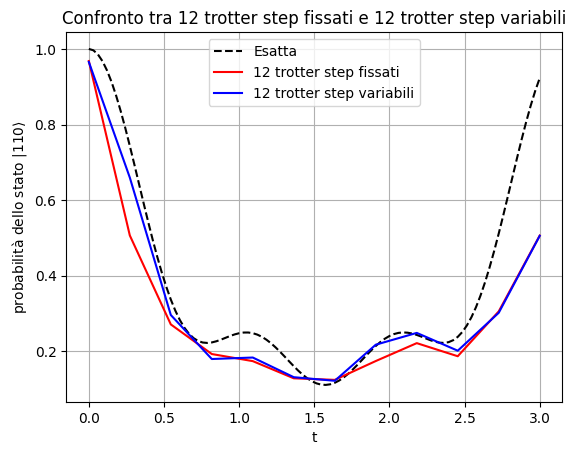

In [32]:
#plottiamo
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="12 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="12 trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 12 trotter step fissati e 12 trotter step variabili')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed12_vs_variable12.png')
plt.show()


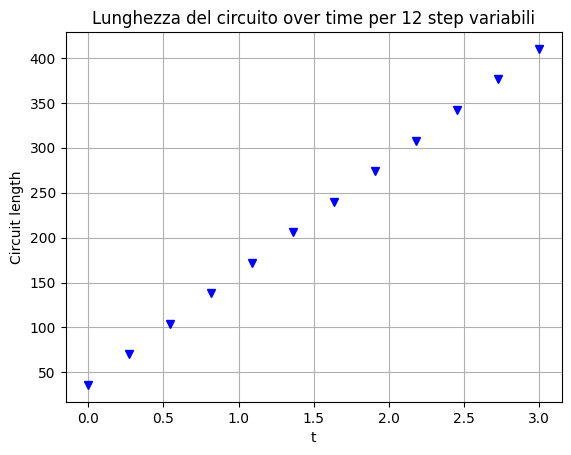

In [27]:
#plottiamo
plt.plot(ts, probs_variable_size,'v', color="blue", )
plt.xlabel('t')
plt.ylabel(r'Circuit length')
plt.title(r'Lunghezza del circuito over time per 12 step variabili')
plt.grid()
plt.savefig('../../png/parameters_change/12variable_size.png')
plt.show()


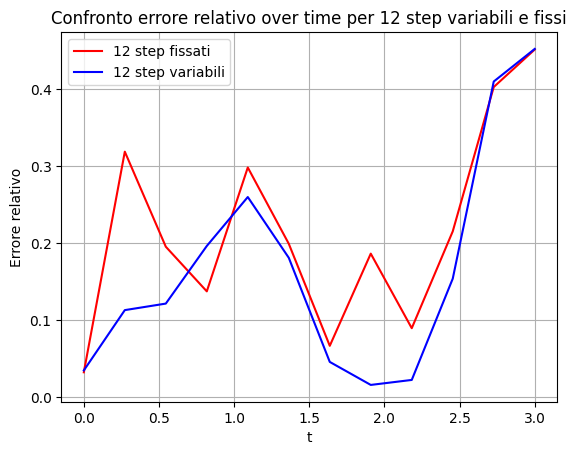

In [33]:
#plottiamo

plt.plot(ts, probs_fixed_error,color="red",label="12 step fissati")
plt.plot(ts, probs_variable_error,color="blue",label="12 step variabili")
plt.xlabel('t')
plt.ylabel(r'Errore relativo')
plt.title(r'Confronto errore relativo over time per 12 step variabili e fissi')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/12fix_Vs_12var_relative_error.png')
plt.show()


## 60 TROTTER STEP

In [34]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 60 #così ogni step è di 0.05
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
ts = np.linspace(0, 3, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 60

probs_fixed = [] #depositiamo i valori con trotter step fissati = 60
probs_fixed_error = []


#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)
    
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_fixed_error.append(delta)
    
print(str(trotter_steps_fixed) + " fixed steps completed")


60 fixed steps completed


In [35]:
#facciamo andare il circuito con trotter step variabili (fino a 60)
trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore fino a 60
probs_variable = []
probs_variable_error = []

for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)
    
    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_variable_error.append(delta)
    
    if(trotter_steps_variable % 10 == 0): 
        print(str(trotter_steps_variable) + " steps completed")
    
    trotter_steps_variable = trotter_steps_variable + 1 


10 steps completed
20 steps completed
30 steps completed
40 steps completed
50 steps completed
60 steps completed


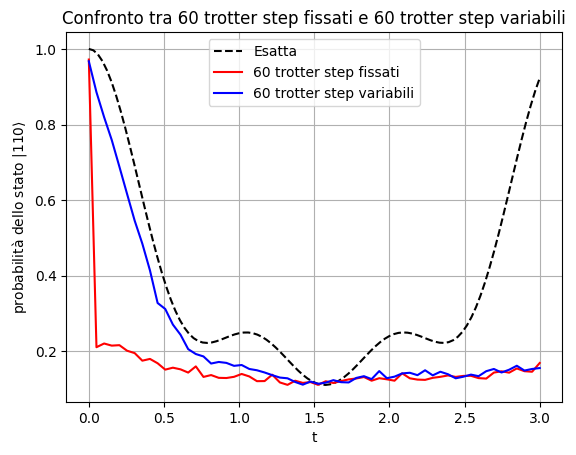

In [10]:
#plottiamo 60 fixed vs 60 variable
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="60 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="60 trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 60 trotter step fissati e 60 trotter step variabili')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed60_vs_60variable.png')
plt.show()

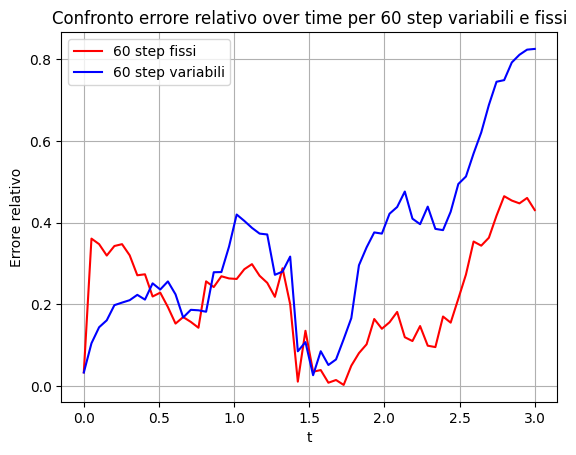

In [41]:
#plottiamo

plt.plot(ts, probs_fixed_error,color="red",label="60 step fissi")
plt.plot(ts, probs_variable_error,color="blue",label="60 step variabili")
plt.xlabel('t')
plt.ylabel(r'Errore relativo')
plt.title(r'Confronto errore relativo over time per 60 step variabili e fissi')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/60fix_Vs_60var_relative_error.png')
plt.show()


## 12 TROTTER STEP FISSATI VS VARIABILI FINO A 60

In [37]:
#La curva esatta

#definiamo il numero di time steps
t_steps = 60 #così ogni step è di 0.05
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
ts = np.linspace(0, 3, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


trotter_steps_fixed = 12
trotter_steps_variable = 1 #inizializziamo ad uno e aumenteremo il valore 
probs_fixed = [] 
probs_variable = []
probs_fixed_error = [] 
probs_variable_error = []


#facciamo andare il circuito con trotter step fissati
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_fixed,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_fixed.append(trotter_value.mean().real)

    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_fixed_error.append(delta)

    
print(str(trotter_steps_fixed) + "fixed steps completed")


12fixed steps completed


In [38]:
#facciamo andare il circuito con trotter step variabili
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)

    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=trotter_steps_variable,t=sim_t)
    qc = qc.compose(trott_steps)

        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    estimator       = BackendEstimator(backend=fake_backend)
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_variable.append(trotter_value.mean().real)

    exact_value = np.abs((initial_state @ U_Heis(3,float(sim_t)) @ initial_state))**2
    delta = np.abs(exact_value - trotter_value.mean().real)/(exact_value)
    probs_variable_error.append(delta)


    if(trotter_steps_variable % 10 == 0): 
        print(str(trotter_steps_variable) + " steps completed")

    trotter_steps_variable = trotter_steps_variable + 1 

10 steps completed
20 steps completed
30 steps completed
40 steps completed
50 steps completed
60 steps completed


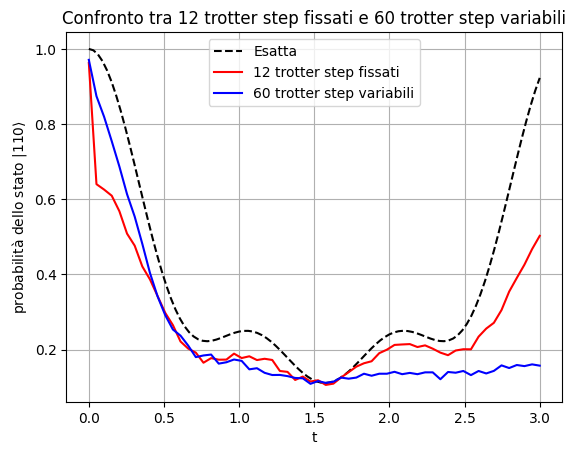

In [13]:

#plottiamo
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_fixed,color="red",label="12 trotter step fissati")
plt.plot(ts, probs_variable,color="blue",label="60 trotter step variabili")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto tra 12 trotter step fissati e 60 trotter step variabili')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/fixed12_vs_variable60.png')
plt.show()

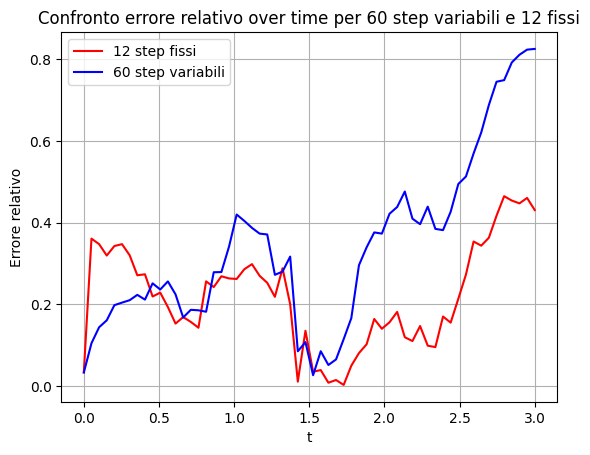

In [40]:
#plottiamo

plt.plot(ts, probs_fixed_error,color="red",label="12 step fissi")
plt.plot(ts, probs_variable_error,color="blue",label="60 step variabili")
plt.xlabel('t')
plt.ylabel(r'Errore relativo')
plt.title(r'Confronto errore relativo over time per 60 step variabili e 12 fissi')
plt.legend()
plt.grid()
plt.savefig('../../png/parameters_change/12fix_Vs_60var_relative_error.png')
plt.show()
